[官方教學](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

---

# [PennFudan Dataset](https://www.cis.upenn.edu/~jshi/ped_html/)

```
PennFudanPed
├─ Annotation
|  ├─ FudanPed00001.txt
|  ├─ FudanPed00002.txt
|  ...
├─ PedMasks
|  ├─ FudanPed00001_mask.png
|  ├─ FudanPed00002_mask.png
|  ...
├─ PNGImages
|  ├─ FudanPed00001.png
|  ├─ FudanPed00002.png
|  ...
├─ added-object-list.txt
└─ readme.txt
```

In [1]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision.transforms import v2

class PennFudan(Dataset):
    """PennFudan Dataset.

    Attributes:
        image_names (list): Image names.
        images (list): Images.
        target (list): The dictionaries of ground truth.
            {'boxes' (torchvision.tv_tensors.BoundingBoxes): The bounding boxes for each object in [x_min, y_min, x_max, y_max] format,
             'labels' (torch.Tensor): The labels for each object. There is only one class: pedestrian,
             'masks' (torchvision.tv_tensors.Mask): The segmentation masks for each object}
    """

    def __init__(self, root, train=True, transform=v2.ToDtype(torch.float32, scale=True)):
        """
        Args:
            root (str): The root directory of PennFudan dataset.
            train (bool): If True, return training data; else, return testing data.
            transform (torchvision.transforms.v2): Data transformation.
        """
        self._transform = transform

        # Get the paths of all images and masks

        if train:
            image_names = os.listdir(os.path.join(root, 'PNGImages'))[:-50]
        else:
            image_names = os.listdir(os.path.join(root, 'PNGImages'))[-50:]
        image_paths = [os.path.join(root, 'PNGImages', name) for name in image_names]
        mask_names = [f'{os.path.splitext(name)[0]}_mask.png' for name in image_names]
        mask_paths = [os.path.join(root, 'PedMasks', name) for name in mask_names]
        self.image_names = [os.path.splitext(name)[0] for name in image_names]

        # Load data

        self.images = []
        self.targets = []
        for image_path, mask_path in zip(image_paths, mask_paths):

            # Load image

            image = read_image(image_path)
            image = tv_tensors.Image(image)

            # Load mask

            mask = read_image(mask_path)
            object_ids = torch.unique(mask) # torch.unique()：找出 tensor 中元素的種類
            object_ids = object_ids[1:] # 0 為背景，去掉 0
            masks = (mask == object_ids[:, None, None]).to(torch.uint8) # 將 mask 轉成一個物件一張圖
            masks = tv_tensors.Mask(masks)

            # Get bounding boxes

            boxes = masks_to_boxes(masks)
            boxes = tv_tensors.BoundingBoxes(boxes, format='XYXY', canvas_size=image.shape[-2:])

            # Generate labels

            labels = torch.ones(len(object_ids), dtype=torch.int64) # 此資料集的物件類別只有一種

            # Append data

            target = {'boxes': boxes, 'labels': labels, 'masks': masks}
            self.images.append(image)
            self.targets.append(target)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Input index.

        Returns:
            image (torchvision.tv_tensors.Image): An image.
            target (dict): {'boxes' (torchvision.tv_tensors.BoundingBoxes): The bounding boxes for each object,
                            'labels' (torch.Tensor): The labels for each object,
                            'masks' (torchvision.tv_tensors.Mask): The segmentation masks for each object}.

        Shape:
            image: (C, H, W).
            target: {'boxes': (N, 4),
                     'labels': (N),
                     'masks': (N, H, W)}.
        """
        image, target = self._transform(self.images[idx], self.targets[idx])
        return image, target

    def get_num_classes(self):
        return 2

In [2]:
def collate_fn(batch):
    """Customized collate_fn for dataloader.

    Args:
        batch (list): [dataset[0], dataset[1], ...].
    """
    return tuple(zip(*batch)) # zip(*batch) = zip(dataset[0], dataset[1], ...)

In [3]:
root = r'C:\Datasets\PennFudanPed'

dataset = PennFudan(root)
print('dataset length =', len(dataset))

dataset length = 120


In [4]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
dataiter = iter(dataloader)
images, targets = next(dataiter)
print('images length =', len(images))
print('targets length =', len(targets))

images length = 2
targets length = 2


In [5]:
print('image:', type(images[0]), images[0].dtype, images[0].shape)
print('boxes:', type(targets[0]['boxes']), targets[0]['boxes'].dtype, targets[0]['boxes'].shape)
print('labels:', type(targets[0]['labels']), targets[0]['labels'].dtype, targets[0]['labels'].shape)
print('masks:', type(targets[0]['masks']), targets[0]['masks'].dtype, targets[0]['masks'].shape)

image: <class 'torchvision.tv_tensors._image.Image'> torch.float32 torch.Size([3, 436, 786])
boxes: <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> torch.float32 torch.Size([5, 4])
labels: <class 'torch.Tensor'> torch.int64 torch.Size([5])
masks: <class 'torchvision.tv_tensors._mask.Mask'> torch.uint8 torch.Size([5, 436, 786])


# [Transformation](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html)

In [6]:
transform = v2.RandomPerspective(distortion_scale=0.5, p=1.0)
to_uint8 = v2.ToDtype(torch.uint8, scale=True) # Convert image to torch.uint8 and [0, 255]

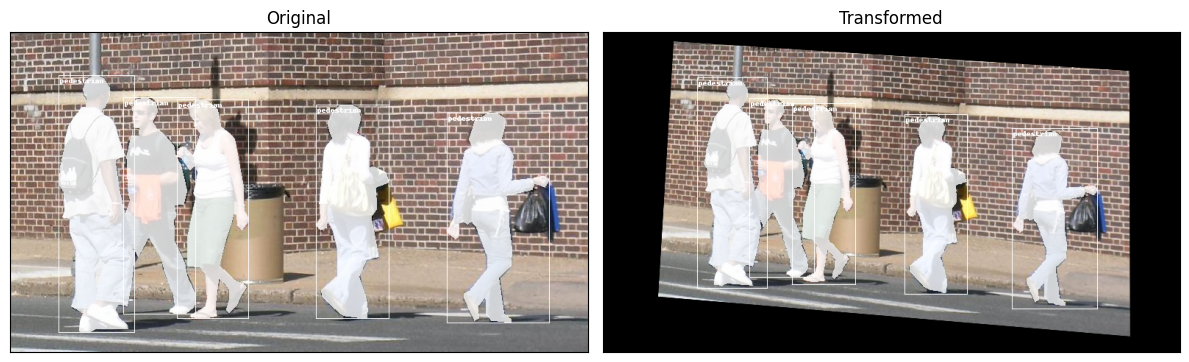

In [7]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image, target = images[0], targets[0]
image_0 = to_uint8(image)
for detection in zip(*target.values()):
    box = detection[0].unsqueeze(0) # (1, 4)
    mask = detection[2].to(torch.bool) # (height, width)
    image_0 = draw_bounding_boxes(image_0, box, labels=['pedestrian'], colors=['white'])
    image_0 = draw_segmentation_masks(image_0, mask, colors=['white'])

image, target = transform(images[0], targets[0])
image_1 = to_uint8(image)
for detection in zip(*target.values()):
    box = detection[0].unsqueeze(0) # (1, 4)
    mask = detection[2].to(torch.bool) # (height, width)
    image_1 = draw_bounding_boxes(image_1, box, labels=['pedestrian'], colors=['white'])
    image_1 = draw_segmentation_masks(image_1, mask, colors=['white'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_0.permute(1, 2, 0))
axes[0].set_title('Original')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(image_1.permute(1, 2, 0))
axes[1].set_title('Transformed')
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.tight_layout()
plt.show()

# [Faster R-CNN](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)

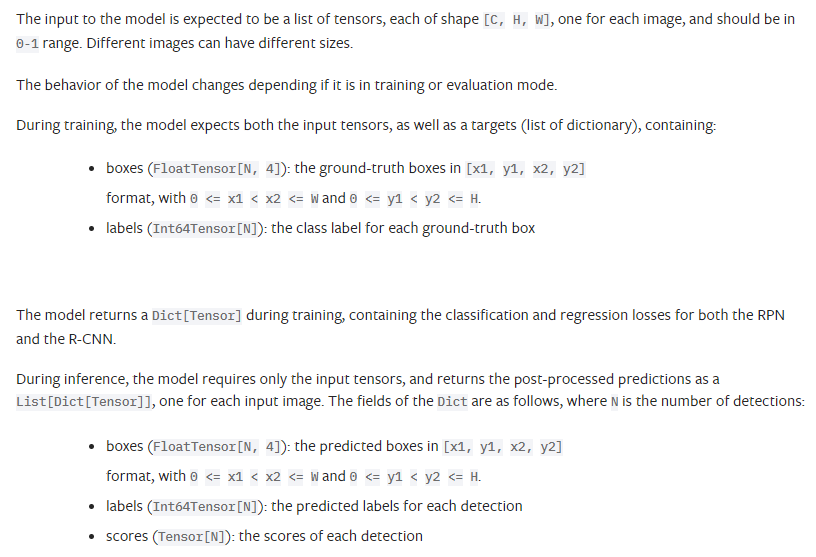

In [8]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [9]:
fasterrcnn = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
fasterrcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [10]:
in_features = fasterrcnn.roi_heads.box_predictor.cls_score.in_features
fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, dataset.get_num_classes())
fasterrcnn

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [11]:
fasterrcnn.train()
outputs = fasterrcnn(images, targets)
outputs

{'loss_classifier': tensor(0.7693, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.3130, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0071, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0028, grad_fn=<DivBackward0>)}

In [12]:
fasterrcnn.eval()
outputs = fasterrcnn(images)
outputs

[{'boxes': tensor([[ 82.6914, 165.4512, 358.1685, 265.1660],
          [170.2279, 190.1756, 209.0701, 261.4504],
          [  5.1270, 162.5799, 272.5548, 256.8825],
          [ 11.8329, 192.1212, 237.0809, 298.8874],
          [149.3323, 196.8438, 173.0310, 268.1104],
          [623.6324, 206.3595, 634.1656, 255.2380],
          [110.0450, 188.9665, 330.1055, 311.6250],
          [446.7042, 166.9007, 486.2799, 242.5563],
          [244.2595, 158.6436, 251.5775, 188.2173],
          [489.6075, 222.8799, 506.6930, 308.4400],
          [462.6096, 159.1966, 511.9571, 306.2929],
          [240.8114, 159.2429, 249.2393, 181.5247],
          [149.4891, 181.5062, 170.3188, 225.2393],
          [433.4059, 182.7092, 475.4981, 242.8392],
          [237.5084, 148.5632, 244.7141, 154.9525],
          [244.1310, 156.2127, 250.4022, 164.7953],
          [447.2582, 163.1758, 523.4235, 254.8188],
          [238.2293, 150.4007, 245.3151, 158.2152],
          [233.4581, 157.8869, 240.0412, 167.1514],
   

In [13]:
print('outputs length =', len(outputs))

outputs length = 2


In [14]:
print('boxes:', type(outputs[0]['boxes']), outputs[0]['boxes'].dtype, outputs[0]['boxes'].shape)
print('labels:', type(outputs[0]['labels']), outputs[0]['labels'].dtype, outputs[0]['labels'].shape)
print('scores:', type(outputs[0]['scores']), outputs[0]['scores'].dtype, outputs[0]['scores'].shape)

boxes: <class 'torch.Tensor'> torch.float32 torch.Size([100, 4])
labels: <class 'torch.Tensor'> torch.int64 torch.Size([100])
scores: <class 'torch.Tensor'> torch.float32 torch.Size([100])


# [Mask R-CNN](https://pytorch.org/vision/stable/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html)

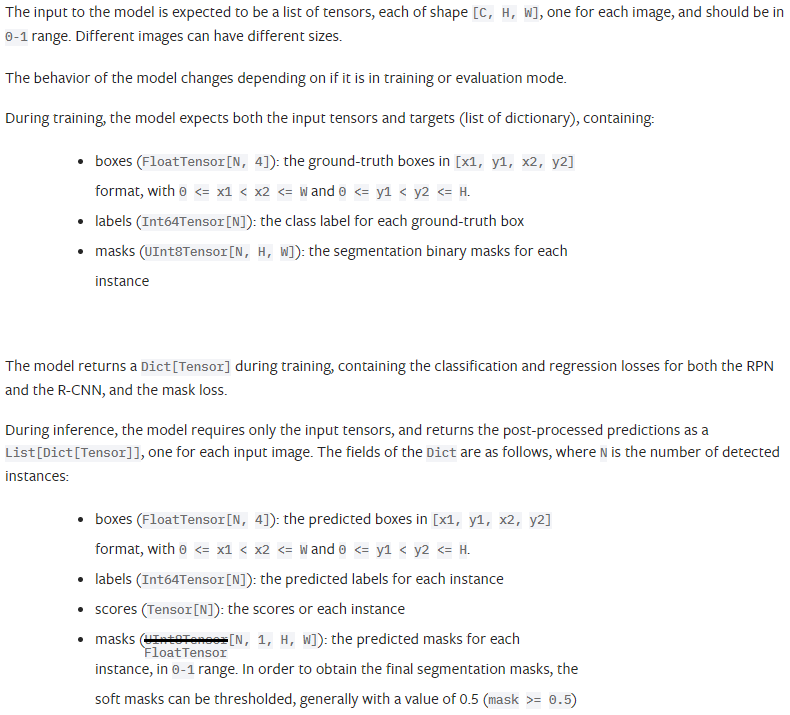

In [15]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [16]:
maskrcnn = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')
maskrcnn

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [17]:
in_features_box = maskrcnn.roi_heads.box_predictor.cls_score.in_features
in_features_mask = maskrcnn.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = maskrcnn.roi_heads.mask_predictor.conv5_mask.out_channels
maskrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, dataset.get_num_classes())
maskrcnn.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, dataset.get_num_classes())
maskrcnn

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [18]:
maskrcnn.train()
outputs = maskrcnn(images, targets)
outputs

{'loss_classifier': tensor(0.5887, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.3418, grad_fn=<DivBackward0>),
 'loss_mask': tensor(1.3972, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.0044, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0045, grad_fn=<DivBackward0>)}

In [19]:
maskrcnn.eval()
outputs = maskrcnn(images)
outputs

[{'boxes': tensor([[7.0386e+02, 2.0275e+02, 7.3552e+02, 2.7357e+02],
          [2.4218e+02, 1.5961e+02, 2.5098e+02, 1.7117e+02],
          [2.4511e+02, 1.4939e+02, 2.5370e+02, 1.7140e+02],
          [6.1791e+02, 8.6196e+01, 7.3921e+02, 3.3205e+02],
          [2.3607e+02, 1.4880e+02, 2.4836e+02, 1.8362e+02],
          [2.2214e+02, 1.5099e+02, 2.3478e+02, 1.5833e+02],
          [2.4172e+02, 1.5038e+02, 2.5170e+02, 1.8457e+02],
          [2.2377e+02, 1.5069e+02, 2.3458e+02, 1.7063e+02],
          [2.3740e+02, 1.6122e+02, 2.4677e+02, 1.9064e+02],
          [2.3008e+02, 1.5104e+02, 2.3800e+02, 1.6706e+02],
          [2.6017e+02, 9.3393e+01, 3.4077e+02, 3.3275e+02],
          [2.2274e+02, 1.5759e+02, 2.3292e+02, 1.7409e+02],
          [2.3271e+02, 1.5131e+02, 2.4006e+02, 1.6584e+02],
          [2.2498e+02, 1.6765e+02, 2.3158e+02, 1.7634e+02],
          [1.4057e+02, 8.6453e+01, 2.4819e+02, 3.9042e+02],
          [6.7948e+02, 2.0400e+02, 7.3185e+02, 2.7101e+02],
          [2.3692e+02, 1.4943e+

In [20]:
print('outputs length =', len(outputs))

outputs length = 2


In [21]:
print('boxes:', type(outputs[0]['boxes']), outputs[0]['boxes'].dtype, outputs[0]['boxes'].shape)
print('labels:', type(outputs[0]['labels']), outputs[0]['labels'].dtype, outputs[0]['labels'].shape)
print('scores:', type(outputs[0]['scores']), outputs[0]['scores'].dtype, outputs[0]['scores'].shape)
print('masks:', type(outputs[0]['masks']), outputs[0]['masks'].dtype, outputs[0]['masks'].shape)

boxes: <class 'torch.Tensor'> torch.float32 torch.Size([100, 4])
labels: <class 'torch.Tensor'> torch.int64 torch.Size([100])
scores: <class 'torch.Tensor'> torch.float32 torch.Size([100])
masks: <class 'torch.Tensor'> torch.float32 torch.Size([100, 1, 436, 786])


# Training (Mask R-CNN)

In [22]:
def print_loss_and_map(iteration, total_iterations, loss, map):
    """Clean the line and print the loss and mAP.

    Args:
        iteration (int): This iteration.
        total_iterations (int): Total iterations.
        loss (torch.Tensor): Loss value.
        map (torch.Tensor): mAP value.
    """
    string = f'{iteration}/{total_iterations} - loss: {loss:.3f} - mAP: {map:.3f}'
    space = '                                        '
    print(f'\r{space}', end='\r')
    if iteration != total_iterations:
        print(string, end='', flush=True)
    else:
        print(string)

root = r'C:\Datasets\PennFudanPed'
batch_size = 2
num_workers = 0
pin_memory = True
pretrained_weights = 'DEFAULT'
lr = 1e-4
epochs = 2
mask_threshold = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# Load training data

trainset = PennFudan(root=root, train=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, collate_fn=collate_fn,
                         pin_memory=pin_memory, drop_last=True)

In [24]:
# Load model

model = maskrcnn_resnet50_fpn_v2(weights=pretrained_weights)
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = model.roi_heads.mask_predictor.conv5_mask.out_channels
model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, trainset.get_num_classes())
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, trainset.get_num_classes())
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [25]:
from torch import optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Training settings

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(trainloader)*epochs)
metric = MeanAveragePrecision(iou_type='segm') # iou_type = ['bbox', 'segm']

In [26]:
# Start training

loss_history = []
map_history = []
for i in range(epochs):
    print(f'Epoch {i+1}/{epochs}')
    for j, (images, targets) in enumerate(trainloader):
        images = [image.to(device) for image in images]
        targets =  [{key: value.to(device) for key, value in target.items()} for target in targets]

        # Train

        model.train()
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Calculate mAP

        model.eval()
        with torch.no_grad():
            preds = model(images)
            preds = [{key: (value > mask_threshold).squeeze(1) if key == 'masks' else value # 二值化 mask 並刪除多餘的維度
                     for key, value in pred.items()} for pred in preds]
            metric.update(preds, targets)
            maps = metric.compute()
            metric.reset()

        # Record loss and mAP

        loss_history.append(loss.item())
        map_history.append(maps['map'].item())
        print_loss_and_map(j+1, len(trainloader), loss, maps['map'])

Epoch 1/2
60/60 - loss: 0.178 - mAP: 0.825        
Epoch 2/2
60/60 - loss: 0.129 - mAP: 0.907        


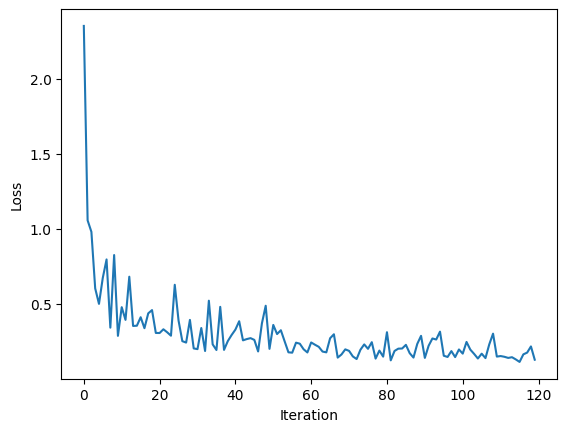

In [27]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

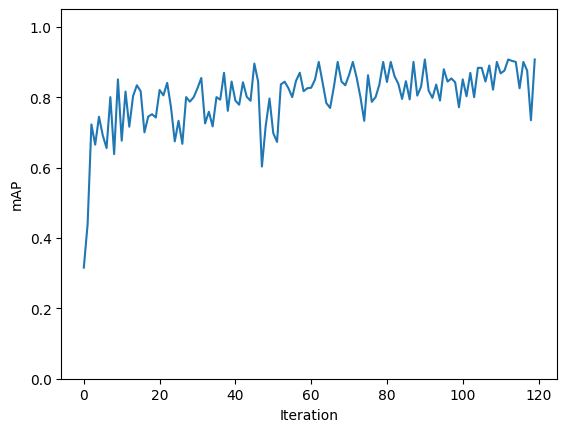

In [28]:
plt.plot(map_history)
plt.xlabel('Iteration')
plt.ylabel('mAP')
plt.ylim([0, 1.05])
plt.show()

# Testing

In [29]:
# Load testing data

testset = PennFudan(root=root, train=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, collate_fn=collate_fn,
                        pin_memory=pin_memory)

In [30]:
# Predict

preds = []
targs = []
with torch.no_grad():
    for images, targets in testloader:
        images = [image.to(device) for image in images]
        targets =  [{key: value.to(device) for key, value in target.items()} for target in targets]
        predictions = model(images)
        preds = preds + predictions
        targs = targs + targets

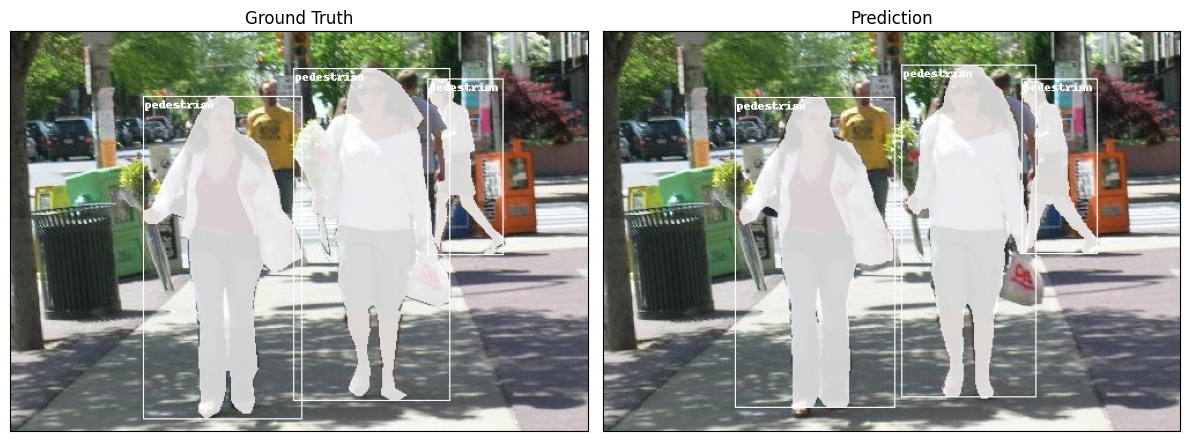

In [31]:
image, target = testset[0]
pred = preds[0]
score_threshold = 0.6

image_0 = to_uint8(image)
for detection in zip(*target.values()):
    box = detection[0].unsqueeze(0)
    mask = detection[2].to(torch.bool)
    image_0 = draw_bounding_boxes(image_0, box, labels=['pedestrian'], colors=['white'])
    image_0 = draw_segmentation_masks(image_0, mask, colors=['white'])

image_1 = to_uint8(image)
for detection in zip(*pred.values()):
    box = detection[0].unsqueeze(0)
    score = detection[2]
    mask = detection[3] > mask_threshold
    if score > score_threshold:
        image_1 = draw_bounding_boxes(image_1, box, labels=['pedestrian'], colors=['white'])
        image_1 = draw_segmentation_masks(image_1, mask, colors=['white'])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_0.permute(1, 2, 0))
axes[0].set_title('Ground Truth')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(image_1.permute(1, 2, 0))
axes[1].set_title('Prediction')
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.tight_layout()
plt.show()

In [32]:
# Calculate mAPs

preds = [{key: (value > mask_threshold).squeeze(1) if key == 'masks' else value
         for key, value in pred.items()} for pred in preds]
metric.update(preds, targs)
maps = metric.compute()
maps

{'map': tensor(0.7954),
 'map_50': tensor(0.9993),
 'map_75': tensor(0.9235),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.7739),
 'map_large': tensor(0.7946),
 'mar_1': tensor(0.3664),
 'mar_10': tensor(0.8336),
 'mar_100': tensor(0.8336),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.8250),
 'mar_large': tensor(0.8350),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}

[COCO Metrics](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173)  
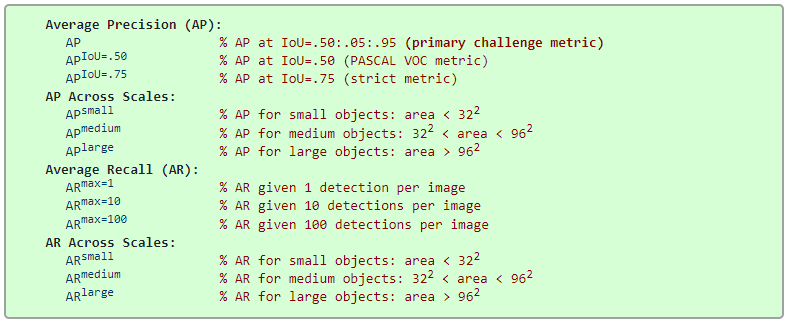